Code for successful analytics. Idea is to eventually rework into functions that can act on a single cumulative df of game shot

For this notebook, will be simply using a single games shot data

In [4]:
import pandas as pd
import networkx as nx

# Set display options to show all columns and a large width
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Adjust the width as needed

shots = pd.read_csv('game_shots_20116.csv')
shots.head()


,Period,Time,Strength,Team,Shooter,Shot Type?,A1,A2,A3,A1 Zone,A2 Zone,A3 Zone,SC?,SOG?,Screen,Situation,Origin,Oddman,G?,Home Score State,Goalie,Game ID,Date,Home:,Away:
0,1,19:33,5v5,EDM,91,t,29.0,27.0,NaN,orrr,nl,NaN,NaN,NaN,NaN,r,nz,NaN,NaN,0,0,20116,10/27/2022,CHI,EDM
1,1,18:57,5v5,EDM,91,w,25.0,5.0,NaN,nl,dr,NaN,NaN,y,NaN,r,dz,NaN,NaN,0,0,20116,10/27/2022,CHI,EDM
2,1,18:40,5v5,EDM,37,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y,NaN,f,oz,NaN,NaN,0,0,20116,10/27/2022,CHI,EDM
3,1,17:38,5v5,CHI,23,w,24.0,23.0,NaN,or,or,NaN,NaN,y,NaN,f,oz,NaN,NaN,0,0,20116,10/27/2022,CHI,EDM
4,1,17:24,5v5,CHI,4,w,43.0,NaN,NaN,opl,NaN,NaN,NaN,NaN,NaN,f,oz,NaN,NaN,0,0,20116,10/27/2022,CHI,EDM


In [5]:
shots['G?'].unique()

array([nan, 'y'], dtype=object)

# NetworkX functions

In [6]:
def create_hockey_network():
    """Create an empty directed graph for hockey analysis"""
    return nx.DiGraph()

def add_player_node(G, team, jersey_number):
    """Add a player node if it doesn't exist"""
    player_id = f"{team}_{jersey_number}"
    if not G.has_node(player_id):
        G.add_node(player_id, team=team, jersey_number=jersey_number, type='player')
    return player_id

def add_shot_node(G, shot_id, is_goal):
    """Add a shot node"""
    G.add_node(shot_id, type='shot', is_goal=is_goal)
    return shot_id

In [ ]:
def process_game_data(df):
    """Process game data and create a network graph"""
    # Create directed graph
    G = create_hockey_network()
    
    # Read CSV data
    #df = pd.read_csv(csv_data) if isinstance(csv_data, str) else pd.DataFrame(csv_data)
    
    # Track passing combinations for weight calculation
    passing_counts = {}
    
    # Process each shot attempt
    for idx, row in df.iterrows():
        # Create shot node
        shot_id = f"shot_{idx}"
        is_goal = True if row['G?'] == 'y' else False
        add_shot_node(G, shot_id, is_goal)
        
        # Add shooter node and connection to shot
        shooter_id = add_player_node(G, row['Team'], row['Shooter'])
        G.add_edge(shooter_id, shot_id, relationship_type='MAKES_SHOT')
        
        # Process passing sequence (A3 -> A2 -> A1 -> Shooter)
        passers = []
        for assist in ['A3', 'A2', 'A1']:
            if pd.notna(row[assist]):
                passer_id = add_player_node(G, row['Team'], int(row[assist]))
                passers.append(passer_id)
        
        # Add passing relationships
        if passers:
            # Include shooter in passing sequence
            passers.append(shooter_id)
            
            # Create edges for consecutive passes
            for i in range(len(passers)-1):
                passer = passers[i]
                receiver = passers[i+1]
                
                # Update passing counts
                pass_key = (passer, receiver)
                passing_counts[pass_key] = passing_counts.get(pass_key, 0) + 1
    
    # Add weighted passing relationships
    for (passer, receiver), weight in passing_counts.items():
        G.add_edge(passer, receiver, relationship_type='PASSES_TO', weight=weight)
    
    return G

In [8]:
def analyze_network(G):
    """Analyze the hockey network and return key metrics"""
    metrics = {
        'total_shots': len([n for n, attr in G.nodes(data=True) if attr['type'] == 'shot']),
        'total_goals': len([n for n, attr in G.nodes(data=True) if attr['type'] == 'shot' and attr['is_goal']]),
        'total_players': len([n for n, attr in G.nodes(data=True) if attr['type'] == 'player']),
        'passing_connections': len([e for e in G.edges(data=True) if e[2].get('relationship_type') == 'PASSES_TO']),
    }
    
    # Calculate player metrics
    player_metrics = {}
    for node in G.nodes():
        if G.nodes[node]['type'] == 'player':
            shots = len([e for e in G.edges(node) if G.edges[e]['relationship_type'] == 'MAKES_SHOT'])
            goals = len([e for e in G.edges(node) if 
                        G.edges[e]['relationship_type'] == 'MAKES_SHOT' and 
                        G.nodes[e[1]]['is_goal']])
            passes = sum(attr['weight'] for _, _, attr in G.edges(node, data=True) 
                        if attr.get('relationship_type') == 'PASSES_TO')
            
            player_metrics[node] = {
                'shots': shots,
                'goals': goals,
                'passes': passes
            }
    
    metrics['player_metrics'] = player_metrics
    return metrics

In [9]:
def visualize_passing_network(G):
    """Create a visualization of the passing network"""
    # Filter to just player nodes and passing relationships
    passing_network = G.copy()
    nodes_to_remove = [n for n, attr in passing_network.nodes(data=True) if attr['type'] == 'shot']
    passing_network.remove_nodes_from(nodes_to_remove)
    edges_to_remove = [e for e in passing_network.edges() if 
                      passing_network.edges[e].get('relationship_type') != 'PASSES_TO']
    passing_network.remove_edges_from(edges_to_remove)
    
    return passing_network

**page rank function**

In [17]:
def calculate_passing_influence(G, alpha=0.85):
    """
    Calculate passing influence scores using PageRank on the passing network
    
    Parameters:
    - G: Full game network
    - alpha: Damping factor for PageRank (default 0.85)
    
    Returns:
    - Dictionary of player IDs and their influence scores
    - Passing-only subgraph
    """
    # Create passing-only subgraph
    passing_network = G.copy()
    
    # Remove shot nodes and non-passing edges
    nodes_to_remove = [n for n, attr in passing_network.nodes(data=True) if attr['type'] == 'shot']
    passing_network.remove_nodes_from(nodes_to_remove)
    edges_to_remove = [e for e in passing_network.edges() if 
                      passing_network.edges[e].get('relationship_type') != 'PASSES_TO']
    passing_network.remove_edges_from(edges_to_remove)
    
    # Extract edge weights for PageRank
    edge_weights = {(u, v): d['weight'] for u, v, d in passing_network.edges(data=True)}
    
    # Calculate PageRank with edge weights
    influence_scores = nx.pagerank(passing_network, alpha=alpha, weight='weight')
    
    # Sort players by influence score
    ranked_players = sorted(influence_scores.items(), key=lambda x: x[1], reverse=True)
    
    return ranked_players, passing_network

def analyze_passing_influence(G):
    """Analyze passing influence and return detailed metrics"""
    influence_rankings, passing_network = calculate_passing_influence(G)
    
    # Calculate additional passing metrics
    metrics = {
        'passing_influence': {},
        'network_stats': {
            'total_passes': sum(d['weight'] for _, _, d in passing_network.edges(data=True)),
            'unique_connections': passing_network.number_of_edges(),
            'active_passers': passing_network.number_of_nodes()
        }
    }
    
    # For each player, calculate comprehensive passing metrics
    for player_id, influence_score in influence_rankings:
        player_data = G.nodes[player_id]
        
        # Calculate direct passing stats
        passes_made = sum(d['weight'] for _, _, d in passing_network.edges(player_id, data=True))
        passes_received = sum(d['weight'] for _, _, d in passing_network.in_edges(player_id, data=True))
        
        metrics['passing_influence'][player_id] = {
            'influence_score': influence_score,
            'team': player_data['team'],
            'jersey_number': player_data['jersey_number'],
            'passes_made': passes_made,
            'passes_received': passes_received,
            'passing_ratio': passes_made / (passes_received + 1),  # Add 1 to avoid division by zero
        }
    
    return metrics

def format_influence_report(metrics):
    """Format the influence metrics into a readable report"""
    report = []
    report.append("=== Passing Influence Report ===\n")
    
    # Network-wide stats
    net_stats = metrics['network_stats']
    report.append(f"Total Passes: {net_stats['total_passes']}")
    report.append(f"Unique Passing Connections: {net_stats['unique_connections']}")
    report.append(f"Active Passers: {net_stats['active_passers']}\n")
    
    # Player rankings
    report.append("Player Rankings by Influence:")
    sorted_players = sorted(
        metrics['passing_influence'].items(),
        key=lambda x: x[1]['influence_score'],
        reverse=True
    )
    
    for player_id, stats in sorted_players:
        report.append(
            f"{stats['team']} #{stats['jersey_number']}: "
            f"Influence: {stats['influence_score']:.3f}, "
            f"Passes: {stats['passes_made']}, "
            f"Received: {stats['passes_received']}"
        )
    
    return "\n".join(report)

## using networkx functions

In [10]:
G = process_game_data(shots)
metrics = analyze_network(G)

In [11]:
passing_network = visualize_passing_network(G)

In [14]:
metrics

{'total_shots': 96,
 'total_goals': 11,
 'total_players': 36,
 'passing_connections': 98,
 'player_metrics': {'EDM_91': {'shots': 6, 'goals': 0, 'passes': 5},
  'EDM_27': {'shots': 2, 'goals': 0, 'passes': 1},
  'EDM_29': {'shots': 4, 'goals': 1, 'passes': 11},
  'EDM_5': {'shots': 1, 'goals': 0, 'passes': 3},
  'EDM_25': {'shots': 10, 'goals': 0, 'passes': 3},
  'EDM_37': {'shots': 2, 'goals': 0, 'passes': 0},
  'CHI_23': {'shots': 1, 'goals': 0, 'passes': 2},
  'CHI_24': {'shots': 2, 'goals': 0, 'passes': 3},
  'CHI_4': {'shots': 6, 'goals': 0, 'passes': 5},
  'CHI_43': {'shots': 2, 'goals': 0, 'passes': 5},
  'CHI_8': {'shots': 1, 'goals': 0, 'passes': 0},
  'CHI_58': {'shots': 1, 'goals': 0, 'passes': 1},
  'CHI_52': {'shots': 3, 'goals': 1, 'passes': 0},
  'EDM_97': {'shots': 4, 'goals': 3, 'passes': 16},
  'EDM_93': {'shots': 4, 'goals': 1, 'passes': 7},
  'CHI_88': {'shots': 7, 'goals': 1, 'passes': 12},
  'CHI_11': {'shots': 2, 'goals': 0, 'passes': 4},
  'CHI_19': {'shots': 3,

In [18]:
influence_metrics = analyze_passing_influence(G)

report = format_influence_report(influence_metrics)

In [20]:
print(report)

=== Passing Influence Report ===

Total Passes: 140
Unique Passing Connections: 98
Active Passers: 36

Player Rankings by Influence:
CHI #88: Influence: 0.116, Passes: 12, Received: 13
EDM #97: Influence: 0.095, Passes: 16, Received: 14
CHI #4: Influence: 0.065, Passes: 5, Received: 9
EDM #29: Influence: 0.060, Passes: 11, Received: 9
EDM #22: Influence: 0.055, Passes: 7, Received: 10
CHI #11: Influence: 0.053, Passes: 4, Received: 5
CHI #19: Influence: 0.052, Passes: 5, Received: 6
EDM #25: Influence: 0.046, Passes: 3, Received: 11
EDM #91: Influence: 0.042, Passes: 5, Received: 7
EDM #93: Influence: 0.032, Passes: 7, Received: 6
EDM #2: Influence: 0.031, Passes: 6, Received: 4
CHI #89: Influence: 0.029, Passes: 2, Received: 5
EDM #13: Influence: 0.024, Passes: 3, Received: 4
CHI #13: Influence: 0.024, Passes: 8, Received: 2
CHI #25: Influence: 0.022, Passes: 2, Received: 4
CHI #24: Influence: 0.021, Passes: 3, Received: 4
CHI #17: Influence: 0.021, Passes: 4, Received: 2
CHI #43: Inf

Top performing trios

In [24]:
import pandas as pd
import networkx as nx
from collections import defaultdict

def analyze_player_combinations_optimized(df, goal_weight=3):
    """
    Efficiently analyze player combinations directly from dataframe
    
    Parameters:
    - df: Pandas DataFrame of shot attempts
    - goal_weight: Weight multiplier for goals vs shots
    
    Returns:
    - Dictionary of pair and trio statistics
    """
    pair_stats = defaultdict(lambda: {'shots': 0, 'goals': 0, 'score': 0})
    trio_stats = defaultdict(lambda: {'shots': 0, 'goals': 0, 'score': 0})
    
    # Process each row directly
    for _, row in df.iterrows():
        # Get all players involved in the sequence
        players = []
        
        # Add shooter
        shooter_id = f"{row['Team']}_{row['Shooter']}"
        players.append(shooter_id)
        
        # Add assisters (if they exist)
        for assist in ['A1', 'A2', 'A3']:
            if pd.notna(row[assist]):
                player_id = f"{row['Team']}_{int(row[assist])}"
                players.append(player_id)
        
        # Score for this sequence
        is_goal = row['G?'] == 'y'
        sequence_score = goal_weight if is_goal else 1
        
        # Process pairs (any 2 players involved)
        if len(players) >= 2:
            for i in range(len(players)):
                for j in range(i + 1, len(players)):
                    pair = tuple(sorted([players[i], players[j]]))
                    pair_stats[pair]['shots'] += 1
                    if is_goal:
                        pair_stats[pair]['goals'] += 1
                    pair_stats[pair]['score'] += sequence_score
        
        # Process trios (any 3 players involved)
        if len(players) >= 3:
            for i in range(len(players)):
                for j in range(i + 1, len(players)):
                    for k in range(j + 1, len(players)):
                        trio = tuple(sorted([players[i], players[j], players[k]]))
                        trio_stats[trio]['shots'] += 1
                        if is_goal:
                            trio_stats[trio]['goals'] += 1
                        trio_stats[trio]['score'] += sequence_score
    
    return {
        'pairs': dict(pair_stats),
        'trios': dict(trio_stats)
    }

def get_top_combinations(combo_stats, n=5):
    """Get top n performing combinations efficiently"""
    # Process pairs
    top_pairs = sorted(
        [(pair, stats) for pair, stats in combo_stats['pairs'].items()],
        key=lambda x: (x[1]['score'], x[1]['goals']),
        reverse=True
    )[:n]
    
    # Process trios
    top_trios = sorted(
        [(trio, stats) for trio, stats in combo_stats['trios'].items()],
        key=lambda x: (x[1]['score'], x[1]['goals']),
        reverse=True
    )[:n]
    
    return {'pairs': top_pairs, 'trios': top_trios}

# Example usage
def analyze_game_combinations(df, goal_weight=3, top_n=5):
    """Quick analysis of top performing combinations"""
    # Read data
    #df = pd.read_csv(csv_data) if isinstance(csv_data, str) else pd.DataFrame(csv_data)
    
    # Get combination stats
    combo_stats = analyze_player_combinations_optimized(df, goal_weight)
    
    # Get top combinations
    return get_top_combinations(combo_stats, top_n)

In [26]:
top_combos = analyze_game_combinations(shots, goal_weight=3, top_n=5)

# Access results
for pair, stats in top_combos['pairs']:
    print(f"Pair {pair}: Goals: {stats['goals']}, Score: {stats['score']}")

for trio, stats in top_combos['trios']:
    print(f"Trio {trio}: Goals: {stats['goals']}, Score: {stats['score']}")

Pair ('CHI_13', 'CHI_88'): Goals: 3, Score: 13
Pair ('CHI_4', 'CHI_88'): Goals: 1, Score: 11
Pair ('CHI_19', 'CHI_88'): Goals: 1, Score: 9
Pair ('EDM_29', 'EDM_97'): Goals: 1, Score: 9
Pair ('EDM_22', 'EDM_29'): Goals: 1, Score: 9
Trio ('CHI_11', 'CHI_13', 'CHI_88'): Goals: 2, Score: 6
Trio ('CHI_19', 'CHI_4', 'CHI_88'): Goals: 1, Score: 6
Trio ('EDM_22', 'EDM_29', 'EDM_97'): Goals: 0, Score: 5
Trio ('CHI_13', 'CHI_19', 'CHI_88'): Goals: 1, Score: 4
Trio ('CHI_13', 'CHI_4', 'CHI_88'): Goals: 1, Score: 4


In [28]:
top_combos = analyze_game_combinations(shots, goal_weight=4, top_n=5)

# Access results
for pair, stats in top_combos['pairs']:
    print(f"Pair {pair}: Goals: {stats['goals']}, Score: {stats['score']}")

for trio, stats in top_combos['trios']:
    print(f"Trio {trio}: Goals: {stats['goals']}, Score: {stats['score']}")

Pair ('CHI_13', 'CHI_88'): Goals: 3, Score: 16
Pair ('CHI_4', 'CHI_88'): Goals: 1, Score: 12
Pair ('EDM_18', 'EDM_97'): Goals: 2, Score: 10
Pair ('EDM_2', 'EDM_97'): Goals: 2, Score: 10
Pair ('CHI_19', 'CHI_88'): Goals: 1, Score: 10
Trio ('CHI_11', 'CHI_13', 'CHI_88'): Goals: 2, Score: 8
Trio ('CHI_19', 'CHI_4', 'CHI_88'): Goals: 1, Score: 7
Trio ('CHI_13', 'CHI_19', 'CHI_88'): Goals: 1, Score: 5
Trio ('CHI_13', 'CHI_4', 'CHI_88'): Goals: 1, Score: 5
Trio ('EDM_22', 'EDM_29', 'EDM_97'): Goals: 0, Score: 5


# visualization testing

In [ ]:
import holoviews as hv
import pandas as pd
import networkx as nx
from holoviews import opts
import param
from bokeh.models import HoverTool

def process_game_data(df):
    """Process game data and create a network graph"""
    # Create directed graph
    G = create_hockey_network()
    
    # Read CSV data
    #df = pd.read_csv(csv_data) if isinstance(csv_data, str) else pd.DataFrame(csv_data)
    
    # Track passing combinations for weight calculation
    passing_counts = {}
    
    # Process each shot attempt
    for idx, row in df.iterrows():
        # Create shot node
        shot_id = f"shot_{idx}"
        is_goal = True if row['G?'] == 'y' else False
        add_shot_node(G, shot_id, is_goal)
        
        # Add shooter node and connection to shot
        shooter_id = add_player_node(G, row['Team'], row['Shooter'])
        G.add_edge(shooter_id, shot_id, relationship_type='MAKES_SHOT')
        
        # Process passing sequence (A3 -> A2 -> A1 -> Shooter)
        passers = []
        for assist in ['A3', 'A2', 'A1']:
            if pd.notna(row[assist]):
                passer_id = add_player_node(G, row['Team'], int(row[assist]))
                passers.append(passer_id)
        
        # Add passing relationships
        if passers:
            # Include shooter in passing sequence
            passers.append(shooter_id)
            
            # Create edges for consecutive passes
            for i in range(len(passers)-1):
                passer = passers[i]
                receiver = passers[i+1]
                
                # Update passing counts
                pass_key = (passer, receiver)
                passing_counts[pass_key] = passing_counts.get(pass_key, 0) + 1
    
    # Add weighted passing relationships
    for (passer, receiver), weight in passing_counts.items():
        G.add_edge(passer, receiver, relationship_type='PASSES_TO', weight=weight)
    
    return G


def create_hockey_network():
    """Create an empty directed graph for hockey analysis"""
    return nx.DiGraph()

def add_player_node(G, team, jersey_number):
    """Add a player node if it doesn't exist"""
    player_id = f"{team}_{jersey_number}"
    if not G.has_node(player_id):
        G.add_node(player_id, team=team, jersey_number=jersey_number, type='player')
    return player_id

def add_shot_node(G, shot_id, is_goal):
    """Add a shot node"""
    G.add_node(shot_id, type='shot', is_goal=is_goal)
    return shot_id

def create_player_centered_network(G, selected_player_id, spring_constant=0.2, node_size=30):
    """
    Create an interactive hub-and-spoke visualization for a selected player's passing network
    
    Parameters:
    - G: NetworkX graph containing full game data
    - selected_player_id: ID of the player to center visualization around
    - spring_constant: Controls the spacing between nodes (lower = more spread out)
    - node_size: Size of the nodes in the visualization
    """
    # Initialize HoloViews with Bokeh backend
    hv.extension('bokeh')
    
    # Get the player's passing connections
    passing_in = [(u, selected_player_id) for u, v, d in G.in_edges(selected_player_id, data=True) 
                  if d.get('relationship_type') == 'PASSES_TO']
    passing_out = [(selected_player_id, v) for u, v, d in G.out_edges(selected_player_id, data=True)
                   if d.get('relationship_type') == 'PASSES_TO']
    
    # Create subgraph with only relevant nodes and edges
    relevant_nodes = {selected_player_id}
    relevant_nodes.update([u for u, _ in passing_in])
    relevant_nodes.update([v for _, v in passing_out])
    
    subgraph = G.subgraph(relevant_nodes)
    
    # Create node positions using spring layout
    # Put selected player in center (0,0) and fix its position
    pos = nx.spring_layout(subgraph, k=spring_constant, 
                          fixed=[selected_player_id],
                          pos={selected_player_id: (0, 0)})
    
    # Create node data for visualization
    node_data = []
    for node in subgraph.nodes():
        node_attrs = G.nodes[node]
        node_data.append({
            'x': pos[node][0],
            'y': pos[node][1],
            'node_id': node,
            'team': node_attrs['team'],
            'jersey': node_attrs['jersey_number'],
            'is_selected': node == selected_player_id
        })
    
    # Create edge data with weights
    edge_data = []
    for u, v in subgraph.edges():
        weight = subgraph[u][v].get('weight', 1)
        edge_data.append({
            'x0': pos[u][0],
            'y0': pos[u][1],
            'x1': pos[v][0],
            'y1': pos[v][1],
            'weight': weight,
            'source': f"{G.nodes[u]['team']} #{G.nodes[u]['jersey_number']}",
            'target': f"{G.nodes[v]['team']} #{G.nodes[v]['jersey_number']}"
        })
    
    # Create HoloViews elements
    # Edges (passing connections)
    edges_df = pd.DataFrame(edge_data)
    edges = hv.Segments(edges_df, 'x0', 'y0', 'x1', 'y1')
    
    # Nodes (players)
    nodes_df = pd.DataFrame(node_data)
    nodes = hv.Points(nodes_df, 'x', 'y')
    
    # Add jersey numbers as labels
    labels = hv.Labels(nodes_df, 'x', 'y', 'jersey')
    
    # Style the visualization
    edges.opts(
        opts.Segments(
            line_width='weight',  # Line width based on number of passes
            line_color='gray',
            tools=['hover'],
            hover_tooltips=[
                ('Source', '@source'),
                ('Target', '@target'),
                ('Passes', '@weight')
            ]
        )
    )
    
    nodes.opts(
        opts.Points(
            size=node_size,
            color='is_selected',  # Different color for selected player
            cmap=['lightblue', 'red'],
            tools=['hover'],
            hover_tooltips=[
                ('Team', '@team'),
                ('Jersey', '@jersey')
            ]
        )
    )
    
    labels.opts(
        opts.Labels(
            text_color='black',
            text_font_size='12pt',
            bgcolor='white',
            text_align='center'
        )
    )
    
    # Combine all elements
    plot = edges * nodes * labels
    
    # Set overall plot options
    plot.opts(
        opts.Plot(
            width=600,
            height=400,
            title=f"Passing Network for {G.nodes[selected_player_id]['team']} #{G.nodes[selected_player_id]['jersey_number']}",
            tools=['pan', 'wheel_zoom', 'reset']
        )
    )
    
    return plot

# Example usage function
def visualize_player_network(df, team, jersey_number):
    """
    Create and display network visualization for a specific player
    """
    # Create the network
    G = process_game_data(df)
    
    # Generate player_id
    player_id = f"{team}_{jersey_number}"
    
    # Create visualization
    return create_player_centered_network(G, player_id)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
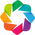

TypeError: Dataset.__new__() takes from 1 to 4 positional arguments but 6 were given

In [33]:
viz = visualize_player_network(shots, team='EDM', jersey_number=97)
viz

In [34]:
import holoviews as hv
import pandas as pd
import networkx as nx
from holoviews import opts
from bokeh.models import HoverTool

def create_player_centered_network(G, selected_player_id,
                                   spring_constant=0.2, node_size=30,
                                   manual_layout=False):
    """
    Create an interactive hub-and-spoke visualization for a selected player's passing network.
    Set manual_layout=True to position inbound passers on the left, the selected player in center, and outbound passers on the right.
    """
    hv.extension('bokeh')

    # Identify inbound and outbound passing edges
    passing_in = [(u, selected_player_id) for u, v, d in G.in_edges(selected_player_id, data=True)
                  if d.get('relationship_type') == 'PASSES_TO']
    passing_out = [(selected_player_id, v) for u, v, d in G.out_edges(selected_player_id, data=True)
                   if d.get('relationship_type') == 'PASSES_TO']

    # Build subgraph with the selected player and direct passers
    relevant_nodes = {selected_player_id}
    relevant_nodes.update([u for u, _ in passing_in])
    relevant_nodes.update([v for _, v in passing_out])
    subgraph = G.subgraph(relevant_nodes).copy()  # copy to avoid read-only issues

    # Create or update a custom layout dict
    pos = {}

    if manual_layout:
        # Place selected player at (0, 0)
        pos[selected_player_id] = (0, 0)

        # Inbound passers on the left side
        in_count = len(passing_in)
        in_spacing = 1.0
        # e.g., center them vertically around y=0
        in_start = -((in_count - 1) * in_spacing) / 2
        for i, (u, _) in enumerate(passing_in):
            pos[u] = (-2, in_start + i * in_spacing)

        # Outbound passers on the right side
        out_count = len(passing_out)
        out_spacing = 1.0
        out_start = -((out_count - 1) * out_spacing) / 2
        for i, (_, v) in enumerate(passing_out):
            pos[v] = (2, out_start + i * out_spacing)

        # Assign any remaining nodes to a ring or default spring
        # (in case you have nodes that appear in passing_in/out multiple times)
        leftover = [n for n in subgraph.nodes() if n not in pos]
        if leftover:
            fallback_pos = nx.spring_layout(subgraph.subgraph(leftover), k=spring_constant)
            for n in leftover:
                pos[n] = fallback_pos[n]

    else:
        # Use a standard spring layout, pinning the selected player to (0,0)
        pos = nx.spring_layout(
            subgraph,
            k=spring_constant,
            fixed=[selected_player_id],
            pos={selected_player_id: (0, 0)}
        )

    # Create DataFrame for node data
    node_data = []
    for node in subgraph.nodes():
        node_attrs = G.nodes[node]
        node_type = node_attrs.get('type', 'player')  # e.g., 'shot' or 'player'
        node_data.append({
            'x': pos[node][0],
            'y': pos[node][1],
            'node_id': node,
            'team': node_attrs.get('team', 'N/A'),
            'jersey': node_attrs.get('jersey_number', 'N/A'),
            'type': node_type,
            'is_selected': (node == selected_player_id)
        })

    # Create DataFrame for edges
    edge_data = []
    for u, v in subgraph.edges():
        edge_attrs = subgraph[u][v]
        relationship = edge_attrs.get('relationship_type', 'unknown')
        weight = edge_attrs.get('weight', 1)
        edge_data.append({
            'x0': pos[u][0],
            'y0': pos[u][1],
            'x1': pos[v][0],
            'y1': pos[v][1],
            'weight': weight,
            'source': f"{G.nodes[u].get('team','N/A')} #{G.nodes[u].get('jersey_number','N/A')}",
            'target': f"{G.nodes[v].get('team','N/A')} #{G.nodes[v].get('jersey_number','N/A')}",
            'relationship': relationship
        })

    # Convert to DataFrames
    nodes_df = pd.DataFrame(node_data)
    edges_df = pd.DataFrame(edge_data)

    # Create HoloViews elements
    edges = hv.Segments(edges_df, kdims=['x0', 'y0', 'x1', 'y1'], vdims=['weight', 'source', 'target', 'relationship'])
    nodes = hv.Points(nodes_df, kdims=['x', 'y'], vdims=['node_id', 'team', 'jersey', 'type', 'is_selected'])

    # Add labels for jersey numbers
    labels = hv.Labels(nodes_df, kdims=['x', 'y'], vdims='jersey')

    # Edge styling
    edges.opts(
        opts.Segments(
            line_width='weight',
            line_color='gray',
            tools=['hover'],
            hover_tooltips=[
                ('Source', '@source'),
                ('Target', '@target'),
                ('Passes', '@weight'),
                ('Type', '@relationship')
            ]
        )
    )

    # Node styling
    nodes.opts(
        opts.Points(
            size=node_size,
            color='is_selected',   # red for selected player, lightblue for others
            cmap=['lightblue', 'red'],
            tools=['hover'],
            hover_tooltips=[
                ('Node ID', '@node_id'),
                ('Team', '@team'),
                ('Jersey', '@jersey'),
                ('Type', '@type')
            ]
        )
    )

    # Label styling
    labels.opts(
        opts.Labels(
            text_color='black',
            text_font_size='12pt',
            bgcolor='white',
            text_align='center',
            text_baseline='middle'  # centers text vertically
        )
    )

    # Combine
    plot = edges * nodes * labels

    # Plot options
    selected_attrs = G.nodes[selected_player_id]
    plot.opts(
        opts.Plot(
            width=600,
            height=400,
            title=f"Passing Network for {selected_attrs.get('team','')} #{selected_attrs.get('jersey_number','')}",
            tools=['pan', 'wheel_zoom', 'reset']
        )
    )
    return plot


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
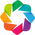

AttributeError: No entry for 'Plot' registered; this name may not refer to a valid object or you may need to run 'hv.extension' to select a plotting backend.

In [35]:
G = process_game_data(shots)

viz = create_player_centered_network(G, 'EDM_97')